# [COM4513/6513] Assignment: Topic Classification with a Feedforward Network


### Instructor: Nikos Aletras, Nafise Sadat Moosavi



**Objective:** This assignment aims to develop a Feedforward Neural Network for classifying news articles into three topics: *Politics*, *Sports*, and *Economy*.

**Dataset:**

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

Class 1: Politics, Class 2: Sports, Class 3: Economy

* `data_topic/train.csv`: 2,400 articles (800 per class) for training.
* `data_topic/dev.csv`: 150 articles (50 per class) for hyperparameter tuning and validation.
* `data_topic/test.csv`: 900 articles (300 per class) for final evaluation.

**Tasks:**

*  **Text Preprocessing (1 mark):**
    * Implement methods to convert raw text into input vectors suitable for your neural network.
   

*  **Feedforward Neural Network Implementation (3 marks):** The network consists of the following components:
    * **Input Layer:** Implement a one-hot encoding followed by an Embedding weight matrix. (**1 mark**)
    * **Hidden Layer:** Calculate the mean embedding vector of all words in the input, and apply a ReLU activation function. (**1 mark**)
    * **Output Layer:** Implement a softmax activation function for multi-class classification. (**1 mark**)
    

*  **Training with Stochastic Gradient Descent (SGD) (6 marks):**
    * Implement the forward pass to compute intermediate outputs. (**2 marks**)
    * Implement the backward pass to compute gradients and update weights. (**3 marks**)
    * Implement and use the Categorical Cross-entropy loss as the objective function. (**1 mark**)
    * Implement and apply dropout regularization after the hidden layer. (**1 mark**)

*  **Hyperparameter Tuning (2 marks):**
    * Systematically tune the following hyperparameters:
        * Learning rate (suggest small values).
        * Embedding size (e.g. 50, 300, 500).
        * Dropout rate (e.g. 0.2, 0.5).
    * Present training and validation performance (loss and accuracy) for different hyperparameter combinations using tables or graphs.
    

*  **Pre-trained Embeddings (GloVe) (1 mark)**:
    * Re-train your neural network using pre-trained GloVe embeddings (300 dimensions) from Common Crawl.
    * Initialize the embedding layer with pre-trained weights.
    * Freeze the embedding weights during training (do not update them).
    * Repeat hyperparameter tuning and learning process analysis.
    * Compare performance with the model using randomly initialized embeddings.

*  **Network Extension (3 marks):**
    * Extend the feedforward network by adding one or two additional hidden layers.
    * Repeat hyperparameter tuning (using a representative subset of combinations).
    * Analyze and discuss the impact of adding more hidden layers on performance.

    
*  **Analysis and Discussion of Results (12 marks):**
    * Justify briefly and concisely all design choices, e.g. text processing, hyperparameters, network architecture. (**2 marks*) 
    * Plot the training and validation loss curves across epochs for all models (excluding the hyperparameter tuning phase). Analyze the learning curves to determine if the model is overfitting, underfitting, or well-fitted. (**2 marks**)
    * Provide a detailed analysis of results, including:
        * Explanations for performance differences between models. (**3 marks**)
        * Error analysis, showing examples and discussion of misclassifications. (**3 marks**)
    * Please provide short and concise justifications.

*  **Code Documentation and Efficiency (3 marks):**
    * Provide well-documented and commented code. (1 mark)
    * Implement efficient solutions using NumPy arrays where possible, ensuring the notebook executes within 10 minutes, excluding hyperparameter tuning and loading pre-trained vectors, on a standard computer (e.g. Intel Core i5, 8/16GB RAM). (2 marks)
    * Refer to Lab 1 for efficiency tips.

**Pre-trained Embeddings:**

* Download GloVe embeddings (glove.840B.300d.zip) from [http://nlp.stanford.edu/data/glove.840B.300d.zip](http://nlp.stanford.edu/data/glove.840B.300d.zip).

**Memory Management:**

* Use `del W` and `gc.collect()` to free memory after each experiment.

**Memory Management:**

* Use `del W` and `gc.collect()` to free memory after each experiment.

**Note:** 
This assignment is designed to be challenging and requires a strong understanding of the underlying mathematical concepts introduced in the class beyond lecture slides. Students are encouraged to consult Chapters 4, 5, 6 and 7 from the [course textbook](https://web.stanford.edu/~jurafsky/slp3/). Good luck!


### Submission Instructions

You **must** submit a Jupyter Notebook file (assignment_yourusername.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`, you need to have a Latex distribution installed e.g. MikTex or MacTex and pandoc). If you are unable to export the pdf via Latex, you can print the notebook web page to a pdf file from your browser (e.g. on Firefox: File->Print->Save to PDF). Failure to submit both the .ipynb and pdf files will result in mark deductions.


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any additional functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results and discussion is as important as the implementation and accuracy of your models. Please be brief and consice in your discussion and analyses. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **15:00 on Thursday, 3 Apr 2025** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade. Use of GenAI is not permitted for this assignment and will be considered as use of unfair means.



In [295]:
import pandas as pd
import numpy as np
from collections import Counter

import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
import zipfile

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [296]:
train_data = pd.read_csv('./data_topic/train.csv', header=None)
dev_data = pd.read_csv('./data_topic/dev.csv', header=None)
test_data = pd.read_csv('./data_topic/test.csv', header=None)

print("Training Data:")
print(train_data.head())

Training Data:
   0                                                  1
0  1  Reuters - Venezuelans turned out early\and in ...
1  1  Reuters - South Korean police used water canno...
2  1  Reuters - Thousands of Palestinian\prisoners i...
3  1  AFP - Sporadic gunfire and shelling took place...
4  1  AP - Dozens of Rwandan soldiers flew into Suda...


In [297]:
X_train = train_data[1]
y_train = train_data[0]

X_dev = dev_data[1]
y_dev = dev_data[0]

X_test = test_data[1]
y_test = test_data[0]

# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [298]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']



### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [299]:
def extract_ngrams(x_raw, ngram_range=(1,2), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    # Step 1: Tokenize using the pattern
    tokens = re.findall(token_pattern, x_raw.lower())

    # Step 2: Remove stop words
    tokens = [token for token in tokens if token not in stop_words]

    # Step 3: Exract ngrams within the given range
    min_n, max_n = ngram_range
    ngrams = []

    for n in range(min_n, max_n + 1):
        for i in range(len(tokens) - n + 1):
            ngram = ' '.join(tokens[i:i + n]) 

            if (not vocab) or (ngram in vocab):
                ngrams.append(ngram)
            
    return ngrams

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency (i.e. number of documents that an ngram appears) as values.
- `ngram_counts`: counts of each ngram in vocab


In [300]:
def get_vocab(X_raw, ngram_range=(1,2), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    df = Counter()
    ngram_counts = Counter()

    # Step 1: Process each document to collect ngram counts and document frequencies
    for doc in X_raw:
        ngrams_in_doc = extract_ngrams(doc, ngram_range=ngram_range, token_pattern=token_pattern,
                                       stop_words=stop_words)
        used_ngarm = []
  
        for ngram in ngrams_in_doc:
            ngram_counts[ngram] += 1

            if ngram not in used_ngarm:
                used_ngarm.append(ngram)
                df[ngram] += 1


    # Step 2: Apply document frequency filter {min_df}
    vocab = {ngram for ngram, freq in df.items() if df[ngram] >= min_df}
    
    # Step 3: Apply top-N frequency filter {keep_topN}
    top_ngrams = [ngram for ngram, _ in ngram_counts.most_common(keep_topN)]
    vocab = set(top_ngrams if keep_topN >0 else ngram_counts)
    
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [301]:
vocabs, df, ngram_counts = get_vocab(
        X_raw=train_data[1], min_df=1, keep_topN=1000, stop_words=stop_words
    )

vocabs

{'former',
 'event',
 'quarterly',
 'retailer',
 'ipo',
 'leave',
 'work',
 'injury',
 'new',
 'storm',
 'british',
 'race',
 'consumer',
 'runs',
 'urged',
 'better',
 'darfur region',
 'republican',
 'city najaf',
 'taking',
 'bomb',
 'three',
 'action',
 'champion',
 'card',
 'angeles',
 'public offering',
 'boost',
 'kenteris',
 'possible',
 'raised',
 'kong',
 'leader',
 'security',
 'end',
 'trial',
 'boston',
 'buy',
 'aug',
 'troops',
 'practice',
 'off',
 'cents',
 'delegates',
 'yet',
 'japan',
 'soccer',
 'match',
 'nortel',
 'reports',
 'xinhuanet',
 'held',
 'double',
 'losing',
 'check',
 'association',
 'euro',
 'sports',
 'venezuela',
 'rule',
 'huge',
 'reserve',
 'najaf',
 'play',
 'defense',
 'yankees',
 'england',
 'west',
 'setting',
 'host',
 'voted',
 'sports network',
 'according',
 'killed',
 'car',
 'charley',
 'greek',
 'also',
 'com',
 'thanou',
 'georgian',
 'popular',
 'bank',
 'financial',
 'nation',
 'olympic games',
 'take',
 'government',
 'claims',
 '

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [302]:
def convert_word_index_mappings(vocabs):
    all_tokens = set()

    for vocab in vocabs:
        all_tokens.add(vocab)

    word_to_id = {word: idx for idx, word in enumerate(all_tokens)}
    id_to_word = {idx: word for word, idx in word_to_id.items()}

    return word_to_id, id_to_word

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [303]:
train_docs = train_data[1]
test_docs = test_data[1]
dev_docs = dev_data[1]

train_vocabs, train_df, train_ngram_counts = get_vocab(
        X_raw=train_docs, min_df=1, keep_topN=1000, stop_words=stop_words
    )
test_vocabs, test_df, test_ngram_counts = get_vocab(
        X_raw=test_docs, min_df=1, keep_topN=1000, stop_words=stop_words
    )
dev_vocabs, dev_df, dev_ngram_counts = get_vocab(
        X_raw=dev_docs, min_df=1, keep_topN=1000, stop_words=stop_words
    )

all_vocabs = set()
for vocab in train_vocabs:
    all_vocabs.add(vocab)




Then convert them into lists of indices in the vocabulary:

In [304]:
all_word_to_id, all_id_to_word = convert_word_index_mappings(all_vocabs)

train_ngrams = [extract_ngrams(doc, stop_words=stop_words) for doc in train_docs]
test_ngrams = [extract_ngrams(doc, stop_words=stop_words) for doc in test_docs]
dev_ngrams = [extract_ngrams(doc, stop_words=stop_words) for doc in dev_docs]


def convert_to_indices(doc, word_to_index):
    indices = []
    for ngram in doc:
        ngram_indice = []
        for vocab in ngram:
            if vocab in word_to_index:
                ngram_indice.append(word_to_index[vocab])
        indices.append(ngram_indice)
    return indices

X_train_indices = convert_to_indices(train_ngrams, all_word_to_id)
X_test_indices = convert_to_indices(test_ngrams, all_word_to_id)
X_dev_indices = convert_to_indices(dev_ngrams, all_word_to_id)

print(X_train_indices)

[[909, 772, 564, 336, 914, 433, 498, 831, 409, 878, 596, 553, 848, 137, 173, 402, 8, 590, 589, 478, 117, 185, 789], [909, 694, 237, 984, 928, 551, 914, 643, 87, 964, 775, 472, 39, 820], [909, 150, 489, 285, 400, 627, 15, 914, 663, 33, 341, 986, 974, 437, 109], [758, 124, 992, 80, 773, 694, 381, 815, 80, 229], [497, 486, 673, 692, 856, 773, 914, 874, 824, 897, 689, 400, 267, 612, 469, 150, 16], [909, 39, 914, 692, 856, 874, 824, 969, 112, 87, 605, 488, 773], [497, 20, 294, 247, 204, 914, 469, 643, 292, 639, 213, 122, 294, 773, 485, 699, 986, 777], [758, 499, 824, 341, 508, 323, 106, 513, 103, 645, 823, 662, 785, 106, 576, 355, 272, 388], [497, 972, 556, 394, 857, 181, 323, 740, 258, 75, 990, 390, 144, 986, 943, 730, 398], [497, 972, 556, 394, 557, 268, 581, 482, 948, 394, 857, 929, 87, 927, 390, 785, 943, 730], [758, 767, 354, 556, 11, 394, 857, 710, 881, 136, 965, 518, 730], [497, 84, 959, 678, 729, 518, 248, 996, 986, 943], [497, 401, 289, 413, 127, 270, 195, 171, 510, 574], [473, 909

Put the labels `Y` for train, dev and test sets into arrays: 

In [305]:
Y_train_array = np.array(train_data[0])
Y_test_array = np.array(test_data[0])
Y_dev_array = np.array(dev_data[0])

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

Then you need to develop a `softmax` function to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [306]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.1):
    W = {}

    # Initialize embedding matrix (vocab_size, embedding_dim)
    W[0] = np.random.uniform(-init_val, init_val, (embedding_dim, vocab_size)).astype(np.float32)

    # Layer sizes (embedding_dim → hidden layers → output)
    layer_sizes = [embedding_dim] + hidden_dim + [num_classes]

    # Initialize weight matrices for hidden and output layers
    for i in range(1, len(layer_sizes)):
        W[i] = np.random.uniform(-init_val, init_val, (layer_sizes[i], layer_sizes[i-1])).astype(np.float32)

    return W
    

In [307]:
W = network_weights(vocab_size=len(all_vocabs),embedding_dim=300,hidden_dim=[2], num_classes=2)
len(W[0])

300

In [308]:
def softmax(z):
    e_z = np.exp(z - np.max(z))  
    sig = e_z / np.sum(e_z, axis=0, keepdims=True)  
    return sig

logits = np.array([-1.9178735e-03, -6.4960841e-05, 3.1698923e-04])
print(softmax(logits))

[0.33287929 0.33349665 0.33362406]


Now you need to implement the categorical cross entropy loss that depends only on the true label `y` and the class probabilities vector `y_preds`:


In [309]:
def categorical_loss(y, y_preds):
    y_preds = np.clip(y_preds, 1e-15, 1. - 1e-15)
    return -np.log(y_preds[y])  

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [310]:
def relu(z):
    
    a = np.maximum(0, z)
    return a
    
def relu_derivative(z):
    
    dz = z.copy()
    dz[dz <= 0] = 0
    dz[dz > 0] = 1
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [311]:
def dropout_mask(size, dropout_rate):
    

    dropout_vec = np.random.rand(size) >  dropout_rate
    return dropout_vec
    
    

In [312]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[False  True False  True  True  True  True  True  True  True]
[False False  True False  True  True False  True  True  True]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [313]:
def indices_to_one_hot(x, vocab_size):
    """
    x: list of int (token indices)
    vocab_size: total number of unique tokens
    return: numpy array of shape (len(x), vocab_size)
    """
    one_hot = np.zeros((vocab_size, len(x)), dtype=np.float32)
    one_hot[x, np.arange(len(x))] = 1.0
    return one_hot
    
def forward_pass(x, W, dropout_rate=0.2):
    out_vals = {}

    # 1. Embedding lookup and averaging
    emb_matrix = W[0]  # shape: (embedding_dim, vocab_size)
    vocab_size = W[0].shape[1]
    one_hot_x = indices_to_one_hot(x, vocab_size)

    emb_output = emb_matrix @ one_hot_x
    emb_out = np.mean(emb_output, axis=1)  # shape: (embedding_dim,)
    # Initialize activations    
    a = emb_out  # Shape: (embedding_dim, 1)
    
    h_vecs = []  # 각 층의 h 값 (입력값)
    a_vecs = []  # 각 층의 a 값 (활성화 후 값)
    dropout_vecs = []  # 각 층의 드롭아웃 마스크

    # Forward through hidden layers
    for i in range(1, len(W) - 1):  # Hidden layers
        h = W[i] @ a   # 가중치 행렬과 입력값 a를 곱함
        h_vecs.append(h)  # 각 층의 입력 벡터(h)
        a_before_dropout = relu(h)  # ReLU 적용
        a = a_before_dropout
        a_vecs.append(a)  # 각 층의 활성화 벡터(a)
      
        
    # Output layer (no activation, just softmax)
    h_out = W[len(W) - 1] @ a
    
    y_pred = softmax(h_out)
    
    # 출력값 저장
    out_vals["h_out"] = h_out
    out_vals["y_pred"] = y_pred

    # 각 층의 출력 값들을 딕셔너리에 저장
    out_vals["emb_out"] = emb_out
    out_vals["h_vecs"] = h_vecs
    out_vals["a_vecs"] = a_vecs
    out_vals["dropout_vecs"] = dropout_vecs
    return out_vals


The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [317]:
def backward_pass(x, y, W, out_vals, learning_rate=0.01, freeze_emb=False):
    # Extract values from forward pass
    h_vecs = out_vals["h_vecs"]  # List of hidden layer outputs
    a_vecs = out_vals["a_vecs"]  # List of pre-activation values
    o_vecs = out_vals["h_out"]
    dropout_vecs = out_vals["dropout_vecs"]  # List of dropout masks
    y_pred = out_vals["y_pred"]  # Output layer logits
    emb_out = out_vals["emb_out"]

    # Compute gradient at output layer
    y_one_hot = np.zeros_like(y_pred)
    y_one_hot[y - 1] = 1  # One-hot encode the true label

    probs = y_pred - y_one_hot  # Gradient of softmax + cross-entropy loss

    # Gradient for last layer (hidden → output)

   
    dW_last = W[len(W) - 1].T @ probs # (3, 128)

    
    delta1 = relu_derivative(h_vecs[len(h_vecs) - 1])
   

    
    W[len(W) - 1] -= learning_rate * dW_last
    


    
    
    # for i in range(len(W) - 2, 0, -1):  # Iterate from last hidden layer to first
    #     h = h_vecs[i-1] # fix index
       

    #     # Gradient for W[i] (previous layer → current layer)
    #     a_prev = h_vecs[i - 2] if i > 1 else emb_out
    #     dW = np.outer(a_prev, delta)
   
    #     # Backpropagate delta to next layer
    #     delta *= relu_derivative(h)
    #     delta = (W[i].T @ delta)

    #    `print(dW.shape)
    #     print(delta.shape)
        
    #     W[i] -= learning_rate * dW
   

    # Backpropagate into embedding layer
    # if not freeze_emb:
    #     for idx in x:
    #         W[0][idx] -= learning_rate * (delta / len(x))  # Average gradient

    return W


Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [318]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.00001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    training_loss_history = []
    validation_loss_history = []
    prev_val_loss = float('inf')
    
    # Data Size
    num_train = len(X_tr)
   
    for epoch in range(epochs):
        epoch_training_loss = 0
        # Learning for individual training from data
        for i in range(num_train):
            x = X_tr[i]  
            y = Y_tr[i]  
            
            # forward
            out_vals = forward_pass(x, W, dropout_rate=dropout)
            # print(out_vals["y_pred"])
           
            # loss
            epoch_training_loss += categorical_loss(y - 1, out_vals["y_pred"])
    
            # backward
            W = backward_pass(x, y, W, out_vals, lr, freeze_emb)

        # Calculating average training loss per epoch
        epoch_training_loss /= num_train
        training_loss_history.append(epoch_training_loss)

        # Verification Loss Calculation
        val_loss = 0
        for i in range(len(X_dev)):
            x_dev = X_dev[i]
            y_dev = Y_dev[i]
            out_vals_dev = forward_pass(x_dev, W, dropout_rate=0)  

            val_loss += categorical_loss(y_dev - 1, out_vals_dev["y_pred"])

        val_loss /= len(X_dev)
        validation_loss_history.append(val_loss)

        # Training/validation loss output
        if print_progress:
            print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {epoch_training_loss:.6f}, Validation Loss: {val_loss:.6f}")

        # 검증 손Training is terminated when the change in validation loss is less than tolerance.
        if abs(prev_val_loss - val_loss) < tolerance and epoch > 50:
            print(f"Training stopped early at epoch {epoch + 1} due to small validation loss change.")
            break

        # 이전 검증 손실 업데이트
        prev_val_loss = val_loss

    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [319]:
import gc

import random
W = network_weights(vocab_size=len(all_vocabs), embedding_dim=300,
                    hidden_dim=[128], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

combined = list(zip(X_train_indices, Y_train_array))
random.shuffle(combined)

X_train_indices_shuffled, y_train_shuffled = zip(*combined)

# W, loss_tr, dev_loss = SGD(X_train_padded, y_train,
#                             W,
#                             X_dev=X_dev_padded, 
#                             Y_dev=y_dev,
#                             lr=0.001, 
#                             dropout=0.5,
#                             freeze_emb=False,
#                             tolerance=0.0000001,
#                             epochs=100)

W, loss_tr, dev_loss = SGD(X_train_indices, Y_train_array,
                            W,
                            X_dev=X_dev_indices, 
                            Y_dev=Y_dev_array,
                            lr=0.001, 
                            dropout=0.0,
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=10)

Shape W0 (300, 1000)
Shape W1 (128, 300)
Shape W2 (3, 128)
Epoch 1/10 - Training Loss: nan, Validation Loss: nan
Epoch 2/10 - Training Loss: nan, Validation Loss: nan
Epoch 3/10 - Training Loss: nan, Validation Loss: nan
Epoch 4/10 - Training Loss: nan, Validation Loss: nan
Epoch 5/10 - Training Loss: nan, Validation Loss: nan


KeyboardInterrupt: 

Plot the learning process:

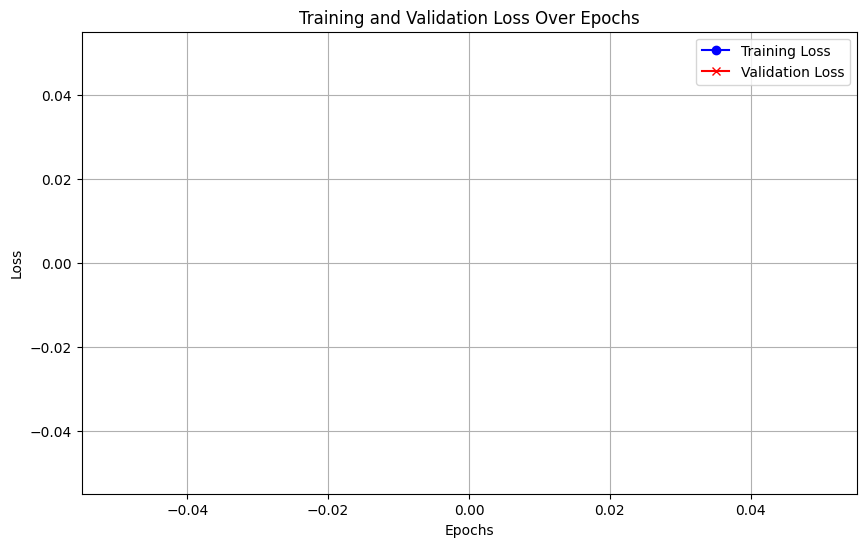

In [273]:
import matplotlib.pyplot as plt

def plot_learning_process(training_losses, validation_losses):
    """
    Plots the learning process by showing the training and validation loss over epochs.

    Parameters:
    - training_losses: List of training losses at each epoch
    - validation_losses: List of validation losses at each epoch
    """
    epochs = range(1, len(training_losses) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, training_losses, label='Training Loss', color='blue', linestyle='-', marker='o')
    plt.plot(epochs, validation_losses, label='Validation Loss', color='red', linestyle='-', marker='x')
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
plot_learning_process(loss_tr, dev_loss)

Compute accuracy, precision, recall and F1-Score:

In [59]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_pred']) 
            for x,y in zip(X_test_indices,Y_test_array)]

print('Accuracy:', accuracy_score(Y_test_array,preds_te))
print('Precision:', precision_score(Y_test_array,preds_te,average='macro'))
print('Recall:', recall_score(Y_test_array,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_test_array,preds_te,average='macro'))

NameError: name 'mask' is not defined

### Discuss how did you choose model hyperparameters ? 

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [26]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in all_vocabs:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [27]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",all_word_to_id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

Shape W0 (19807, 300)
Shape W1 (300, 256)
Shape W2 (256, 128)
Shape W3 (128, 64)
Shape W4 (64, 3)
Epoch 1/100 - Training Loss: 1.098537, Validation Loss: 1.096993
Epoch 2/100 - Training Loss: 1.096155, Validation Loss: 1.093379
Epoch 3/100 - Training Loss: 1.093262, Validation Loss: 1.088168
Epoch 4/100 - Training Loss: 1.088283, Validation Loss: 1.078888
Epoch 5/100 - Training Loss: 1.077595, Validation Loss: 1.056651
Epoch 6/100 - Training Loss: 1.043920, Validation Loss: 0.968847
Epoch 7/100 - Training Loss: 0.871010, Validation Loss: 0.618739
Epoch 8/100 - Training Loss: 0.599174, Validation Loss: 0.409387
Epoch 9/100 - Training Loss: 0.460200, Validation Loss: 0.284301
Epoch 10/100 - Training Loss: 0.380650, Validation Loss: 0.228000
Epoch 11/100 - Training Loss: 0.333519, Validation Loss: 0.205156
Epoch 12/100 - Training Loss: 0.319377, Validation Loss: 0.189816
Epoch 13/100 - Training Loss: 0.319154, Validation Loss: 0.179509
Epoch 14/100 - Training Loss: 0.302459, Validation Lo

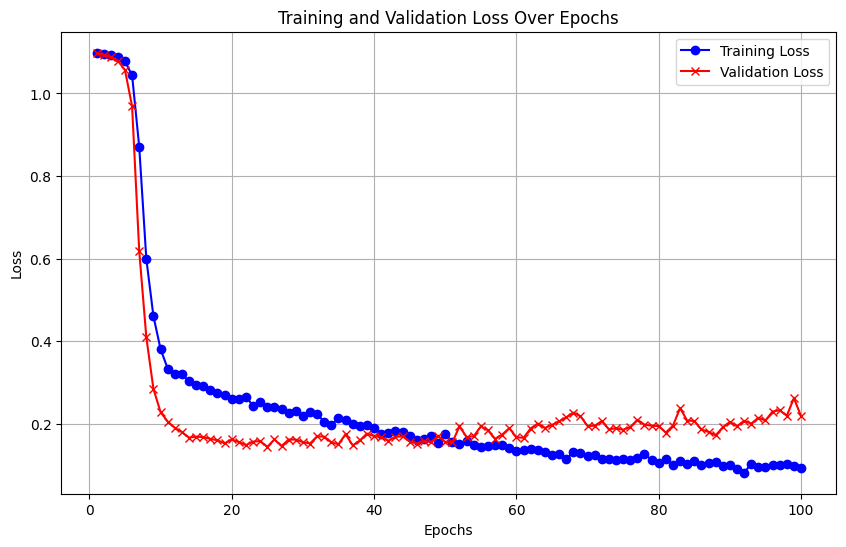

In [28]:
W = network_weights(vocab_size=len(all_vocabs),embedding_dim=300,
                    hidden_dim=[256, 128, 64], num_classes=3)
W[0] = w_glove 

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)



W, loss_tr, dev_loss = SGD(X_train_indices_shuffled, y_train_shuffled,
                            W,
                            X_dev=X_dev_indices, 
                            Y_dev=Y_dev_array,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.00005,
                            epochs=100)
plot_learning_process(loss_tr, dev_loss)

In [29]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_pred']) 
            for x,y in zip(X_test_indices,Y_test_array)]


print('Accuracy:', accuracy_score(Y_test_array,preds_te))
print('Precision:', precision_score(Y_test_array,preds_te,average='macro'))
print('Recall:', recall_score(Y_test_array,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_test_array,preds_te,average='macro'))

Accuracy: 0.028888888888888888
Precision: 0.02110400191187973
Recall: 0.021666666666666667
F1-Score: 0.021379573589340832


/opt/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/py312/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Discuss how did you choose model hyperparameters ? 

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [30]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y']) 
            for x,y in zip(X_te,Y_te)]

print('Accuracy:', accuracy_score(Y_te,preds_te))
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))

NameError: name 'X_te' is not defined

### Discuss how did you choose model hyperparameters ? 

## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  |   |   |   |   |
| Average Embedding (Pre-trained)  |   |   |   |   |
| Average Embedding (Pre-trained) + X hidden layers    |   |   |   |   |


Please discuss why your best performing model is better than the rest and provide a brief error analaysis.